In [1]:
import nbdHelp as ndb
import ndbDELETE as ndb2
from functools import partial

import os
import glob
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import scipy.ndimage
from scipy.spatial import Voronoi, voronoi_plot_2d

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import math
from collections import defaultdict
import numpy as np

import io
import base64
from IPython.display import HTML, display
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter

rc('animation', html='jshtml')


In [2]:
in_path = '/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/df_in.parquet'
out_path = '/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/df_out.parquet'
sup_path = '/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/sup_file.parquet'

df_in = pd.read_parquet(in_path)
df_out = pd.read_parquet(out_path)
sup_file = pd.read_parquet(sup_path)
map_file= pd.read_parquet('/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/mapping_df.parquet')

print('Loaded df_in:', df_in.shape)
print('Loaded df_out:', df_out.shape)
print('Loaded sup_file:', sup_file.shape)
print('Loaded map_file:', map_file.shape)

Loaded df_in: (4880579, 24)
Loaded df_out: (562936, 7)
Loaded sup_file: (18009, 42)
Loaded map_file: (14108, 5)


In [3]:
# Merge df_out with df_in to get player_role for each row
df_out_merged = df_out.merge(df_in[['game_id', 'play_id', 'nfl_id', 'frame_id', 'player_role']],
                      on=['game_id', 'play_id', 'nfl_id', 'frame_id'],
                      how='left')

In [4]:
def prep_for_heat(id, df=None, n=2, angle_unit='rad'):
    """
    Prepare receiver + defender final positions and velocities for a heatmap.

    Inputs:
      - id: play id 
      - df: optional DataFrame; if provided, the function calls
            ndb.get_last_n_frames_coords(id_or_coords, df, n=n)
      - n: number of frames to request when calling get_last_n_frames_coords (default 2)
      - angle_unit: 'deg' (default) or 'rad' for velocity direction units.

    Returns:
      (receiver_final_x, receiver_final_y, receiver_final_v_mag, receiver_final_v_dir),
      defender_positions,   # tuple of (x,y) tuples: ((d1x,d1y),(d2x,d2y),...)
      defender_v_mags,      # tuple of mags: (d1_mag, d2_mag, ...)
      defender_v_dirs       # tuple of directions: (d1_dir, d2_dir, ...)

    Notes / assumptions:
      - get_last_n_frames_coords returns a flat list: (nfl_id, frame_id, x, y, player_role)
      - Velocities are computed from the last two frames for each player (if available).
      - If only one frame exists for a player, v_mag = 0 and v_dir = np.nan.
      - Receiver is detected by player_role starting with 'r' (case-insensitive) or containing 'receiver'.
      - Players whose role contains 'ball' or 'football' are ignored.
    """
    

    
    coords = ndb.get_last_n_frames_coords(id, df, n=n)
    
    # Expect coords: list of (nfl_id, frame_id, x, y, player_role)
    # Group by nfl_id, keep tuples of (frame_id, x, y, role)
    players = defaultdict(list)
    for item in coords:
        try:
            nfl_id, frame_id, x, y, role = item
        except Exception:
            # skip malformed entries
            continue
        players[nfl_id].append((frame_id, float(x), float(y), str(role)))

    # Sort each player's frames by frame_id ascending
    for pid in list(players.keys()):
        players[pid].sort(key=lambda t: t[0])

    # Helper to compute velocity from last two frames (or return 0, nan)
    def compute_vel(frames):
        # frames: list of (frame_id, x, y, role) sorted by frame_id asc
        if len(frames) >= 2:
            _, x1, y1, _ = frames[-2]
            _, x2, y2, _ = frames[-1]
            dx = x2 - x1
            dy = y2 - y1
            mag = np.clip(float(math.hypot(dx, dy))*10,0,10.5)
            ang = float(math.atan2(dy, dx))
            if angle_unit == 'deg':
                ang = math.degrees(ang)
            return mag, ang
        else:
            return 0.0, float('nan')

    # Identify receiver: prefer a player whose most-recent role startswith 'r' or contains 'receiver'.
    receiver_pid = None
    receiver_candidate_frame = -1
    for pid, frames in players.items():
        last_role = frames[-1][3].lower() if frames and frames[-1][3] is not None else ''
        if last_role.startswith('r') or 'receiver' in last_role or 'target' in last_role:
            # choose the candidate with the most recent frame (highest frame id)
            last_frame_id = frames[-1][0]
            if last_frame_id >= receiver_candidate_frame:
                receiver_candidate_frame = last_frame_id
                receiver_pid = pid

    # If none found, try to find a player named 'receiver' anywhere in role strings
    if receiver_pid is None:
        for pid, frames in players.items():
            last_role = frames[-1][3].lower() if frames and frames[-1][3] is not None else ''
            if 'receiver' in last_role:
                receiver_pid = pid
                break

    # Prepare receiver outputs
    if receiver_pid is not None:
        rframes = players[receiver_pid]
        recv_x = float(rframes[-1][1])
        recv_y = float(rframes[-1][2])
        recv_v_mag, recv_v_dir = compute_vel(rframes)
    else:
        # fallback: return NaNs if no receiver detected
        recv_x = float('nan')
        recv_y = float('nan')
        recv_v_mag = 0.0
        recv_v_dir = float('nan')

    # Prepare defender lists: exclude receiver and any 'ball'/'football' roles
    defender_positions = []
    defender_v_mags = []
    defender_v_dirs = []

    for pid in sorted(players.keys()):
        if pid == receiver_pid:
            continue
        frames = players[pid]
        # ignore ball/football if role indicates that
        last_role = frames[-1][3].lower() if frames and frames[-1][3] is not None else ''
        if 'ball' in last_role or 'football' in last_role:
            continue
        # final position
        fx = float(frames[-1][1])
        fy = float(frames[-1][2])
        fmag, fdir = compute_vel(frames)
        defender_positions.append((fx, fy))
        defender_v_mags.append(fmag)
        defender_v_dirs.append(fdir)

    # Convert lists to tuples as requested
    defender_positions = tuple(defender_positions)
    defender_v_mags = tuple(defender_v_mags)
    defender_v_dirs = tuple(defender_v_dirs)

    return (recv_x, recv_y, float(recv_v_mag), float(recv_v_dir)), defender_positions, defender_v_mags, defender_v_dirs

def center_coordinates(rec_info,def_pos):
    rx,ry,_,_=rec_info
    centered_def_pos = []
    for (dx,dy) in def_pos:
        centered_def_pos.append( (dx - rx, dy - ry) )
    return centered_def_pos



In [5]:
start_coords = prep_for_heat(13975,df_in,n=2)
end_coords = prep_for_heat(13975,df_out_merged,n=2)
print(start_coords)
print(end_coords)

((91.0, 14.32, 2.6172504656605233, -0.8124186125846928), ((81.6, 23.72), (95.28, 8.61), (102.5, 15.43), (93.61, 18.39), (93.88, 31.03), (87.72, 48.11), (95.2, 37.52), (93.33, 37.95), (94.14, 11.24), (91.26, 32.96), (103.4, 33.5), (95.9, 46.36)), (0.4472135955000278, 1.2000000000000455, 2.23606797749978, 2.02484567313164, 2.7313000567495305, 1.835755975068569, 3.4438350715445583, 6.400781202322134, 6.2649820430709005, 3.1622776601684017, 2.863564212655306, 1.7204650534085384), (-2.0344439357958803, 3.141592653589793, -0.17985349979248325, -0.9964914966201922, 1.1562894522101126, 1.0584068664841335, 1.120135000714251, 0.5055810548742066, 0.42794849632147697, 0.9652516631899053, 0.43240777557052223, 0.6202494859828263))
((91.41, 12.83, 1.3038404810405415, -1.6475682180647133), ((93.17, 9.82), (93.25, 15.56)), (4.404543109109081, 4.810405388322294), (2.452668265374935, -1.9320000822885808))


In [53]:
def get_voronoi(id,return_data=True):    
    rec_info,def_pos,def_vs,def_vts=prep_for_heat(id,df=df_out_merged,n=2)
    #print('Receiver info (x,y,v_mag,v_dir):', rec_info)
    #print('Defender positions (x,y):', def_pos)
    #print('Defender v_mags:', def_vs)
    #print('Defender v_dirs:', def_vts)
    centered_def_pos = center_coordinates(rec_info,def_pos)
    #print('Centered defender positions (x,y):', centered_def_pos)
    # Call the multi-point plot with the list of fns

    pos1 = (0,0)
    v1=rec_info[2]
    v1t=rec_info[3]
    pos2_list = centered_def_pos
    v2_list=def_vs
    v2t_list=def_vts
    sideline_dist=abs(rec_info[1])
    from functools import partial

    # P1 function
    time_fn_p1 = partial(ndb.optimized_physics_time_wrapper,vi=v1,vt=v1t,astop=12,ago=8,aturnmax=7,vmax=10.5)

    # Make one function per P2 player (bind each player's v and vt)
    time_fn_p2_list = [
        partial(ndb.optimized_physics_time_wrapper,vi=v,vt=vt,astop=12,ago=8,aturnmax=7,vmax=10.5)
        for v, vt in zip(v2_list, v2t_list)
    ]
    
# Call the multi-point plot with the list of fns
    fig, ax, XX, YY, TT1, TT_others, combined = ndb.plot_multi_point_control_map(
        time_fn_p1,
        time_fn_p2_list,
        pos1=pos1,
        pos2_list=pos2_list,
        sideline_dist=sideline_dist,
        vel1=v1t,
        vel2_list=v2t_list,
        vel1mag=v1,
        vel2mag_list=v2_list,
        combine_fn=ndb.soft_ownership(beta=1),
        xlim=(-5, 5),
        ylim=(-5, 5),
        resolution=0.25,
        cmap='grey',
        show_time_contours=False,
        show_vel_direc=True,
        show_people=True,
        gauss_Filter=None,
        arrow_len=0.5
    )
    if return_data:
        #plt.close(fig)
        return XX, YY, combined
    #print(combined.shape)
    #plt.close(fig)
    return fig,ax


def get_voronoi_coords(rec_info,def_pos,def_vs,def_vts,return_data=True):    
    #rec_info,def_pos,def_vs,def_vts=prep_for_heat(id,df=df_out_merged,n=2)
    #print('Receiver info (x,y,v_mag,v_dir):', rec_info)
    #print('Defender positions (x,y):', def_pos)
    #print('Defender v_mags:', def_vs)
    #print('Defender v_dirs:', def_vts)
    centered_def_pos = center_coordinates(rec_info,def_pos)
    #print('Centered defender positions (x,y):', centered_def_pos)
    # Call the multi-point plot with the list of fns

    pos1 = (0,0)
    v1=rec_info[2]
    v1t=rec_info[3]
    pos2_list = centered_def_pos
    v2_list=def_vs
    v2t_list=def_vts
    sideline_dist=abs(rec_info[1])
    #print(sideline_dist)
    from functools import partial

    # P1 function
    time_fn_p1 = partial(ndb.optimized_physics_time_wrapper,vi=v1,vt=v1t,astop=12,ago=8,aturnmax=7,vmax=10.5)

    # Make one function per P2 player (bind each player's v and vt)
    time_fn_p2_list = [
        partial(ndb.optimized_physics_time_wrapper,vi=v,vt=vt,astop=12,ago=8,aturnmax=7,vmax=10.5)
        for v, vt in zip(v2_list, v2t_list)
    ]
    
# Call the multi-point plot with the list of fns
    fig, ax, XX, YY, TT1, TT_others, combined = ndb.plot_multi_point_control_map(
        time_fn_p1,
        time_fn_p2_list,
        pos1=pos1,
        pos2_list=pos2_list,
        sideline_dist=sideline_dist,
        vel1=v1t,
        vel2_list=v2t_list,
        vel1mag=v1,
        vel2mag_list=v2_list,
        combine_fn=ndb.soft_ownership(beta=1),
        xlim=(-1, 5),
        ylim=(-5, 5),
        resolution=0.25,
        cmap='grey',
        show_time_contours=False,
        show_vel_direc=True,
        show_people=True,
        gauss_Filter=None,
        arrow_len=0.5
    )
    if return_data:
        #plt.close(fig)
        return XX, YY, combined
    #print(combined.shape)
    #plt.close(fig)
    return fig,ax



In [7]:
XX,YY,combined=get_voronoi_coords(*end_coords)
def hazToProb(haz):
    return 1/(1+np.exp(-1.442885 + 4.360768 * haz))
probField= hazToProb(combined)



In [8]:
from scipy.interpolate import RegularGridInterpolator

def pk(rx,ry,XX,YY,prob_field):
    #Assumes prob_field is a function prob_field(x,y) giving prob of tackle at (x,y)
    #returns value of prob_field at (rx,ry)
    #print(rx,ry,XX,YY)
    interpolator = RegularGridInterpolator((YY[:,0], XX[0]), prob_field)
    return interpolator((ry, rx))

def calc_prob_of_tackle_along_path(path_points,XX,YY,prob_field,dist):
    #Calculate probability of tackle along a given path
    p_survive=1
    pkt=[]
    for pt in path_points:
        rx,ry=pt
        pk_val=pk(rx,ry,XX,YY,prob_field)
        lambd=-np.log(1-pk_val)
        pk_val=1-np.exp(-lambd*dist)
        pkt.append(p_survive*pk_val)
        p_survive *= (1 - pk_val)
    return p_survive, pkt

def expected_val_receiver(path_points, p_survive, pkt, move_direc="y"):
    #Calculate expected value of receiver position along path
    ev=0
    for i,pt in enumerate(path_points):
        rx,ry=pt
        if move_direc=="y":
            ev += ry * pkt[i]
        else:
            ev += rx * pkt[i]
    #print(path_points[-1][1])
    ev += (path_points[-1][1] if move_direc=="y" else path_points[-1][0]) * p_survive
    return ev

def getPathExpectedVal(pts,XX,YY,probField,locald):
    #Given a set of path points, calculate expected value and return negative (for minimization)
    p_survive, pkt=calc_prob_of_tackle_along_path(pts, XX, YY, probField, locald)
    exp_val=expected_val_receiver(pts, p_survive, pkt, move_direc="x")
    return -exp_val

def multiLinearPath(xi,yi,ti,turns,dists,n_points):
    #Generate a multi-linear path given initial position/direction, list of turns and distances
    points=[]
    x=0
    y=0
    angle=ti
    total_d=sum(dists)
    points_added=0
    for seg_i in range(len(turns)):
        d=dists[seg_i]
        turn=turns[seg_i]
        #print(n_points,d,total_d)
        seg_points= max(1, int(n_points * (d/total_d)))
        for i in range(seg_points):
            if points_added>=n_points:
                break
            points.append( (xi + x, yi + y) )
            x += d/seg_points * np.cos(angle)
            y += d/seg_points * np.sin(angle)
            points_added+=1
        angle += turn
    #Ensure exactly n points
    while len(points)<n_points:
        points.append( (xi + x, yi + y) )
    return points
        
def path_step_distance(pts):
    """
    Return mean step distance and full array of step lengths for a path.
    """
    arr = np.asarray(pts, dtype=float)
    if len(arr) < 2:
        return 0.0, np.array([])
    dx = np.diff(arr[:,0])
    dy = np.diff(arr[:,1])
    d = np.hypot(dx, dy)
    return float(d.mean()), d

In [9]:
def get_best_path(XX,YY,probField):
    best_theta=-1
    best_exp = 0
    theta_range=np.linspace(-2,2,20)
    for th in theta_range:
        pts = multiLinearPath(0,0,th,[0],[10],50)
        # restrict pts to the XX/YY grid bounds
        x_min, x_max = XX.min(), XX.max()
        y_min, y_max = YY.min(), YY.max()
        pts = [(x, y) for x, y in pts if (x_min <= x <= x_max) and (y_min <= y <= y_max)]
        if not pts:
            continue
        locald=path_step_distance(pts)[0]
        exp=-1*getPathExpectedVal(pts,XX,YY, probField, locald)
        if exp>=best_exp:
            best_exp=exp
            best_theta=th
    pts=multiLinearPath(0,0,best_theta,[0],[5],50)
    locald=path_step_distance(pts)[0]
    exp=-1*getPathExpectedVal(pts,XX,YY, probField, locald)
    
    return pts,exp,locald

In [10]:
pts,exp,locald=get_best_path(XX,YY,probField)

In [55]:
def get_avg(combined, window_size=4):
    #Get CSD for a given id

    CSD_array = combined
    #print(CSD_array.shape)

    # scale pixels so 0 -> 0 and 255 -> 1
    CSD_array = CSD_array.astype(float)

    sigma = 1
    CSD_array = gaussian_filter(CSD_array.astype(float), sigma=sigma)
    CSD_array = np.clip(CSD_array, 0, 255)

    #Take the average around the center with window size

    center_x, center_y = CSD_array.shape[1] // 2, CSD_array.shape[0] // 2
    window = CSD_array[center_y - window_size//2 : center_y + window_size//2,
                       center_x - window_size//2 : center_x + window_size//2]
    average = np.mean(window)
    maxv=np.max(CSD_array)
    minv=np.min(CSD_array)

    print(average,maxv,minv)



    return average, maxv, minv

def avg_to_prob(avg):
    return 1 / (1 + np.exp(-(-0.687262 + 3.304681 * avg)))

In [12]:
avg,maxv,minv=get_avg(combined)
prob=avg_to_prob(avg)
print(prob)

0.642997783081144


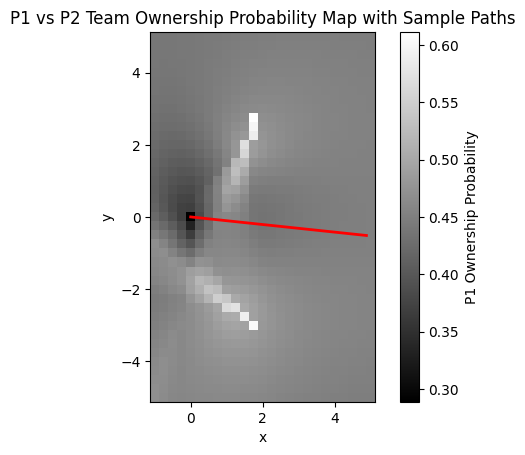

Expected y position of receiver along path: -0.17481848727199348
P_Survive: 0.05628270269433805


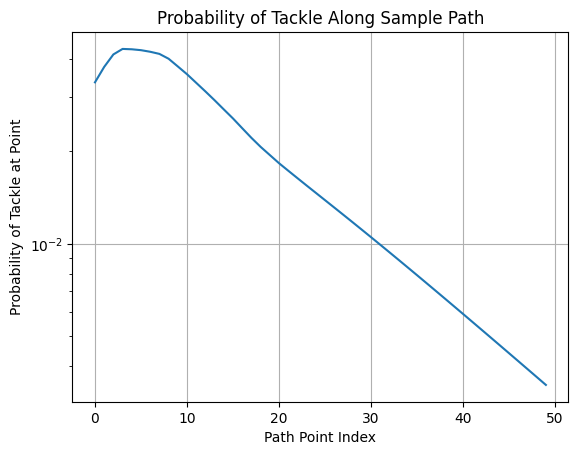

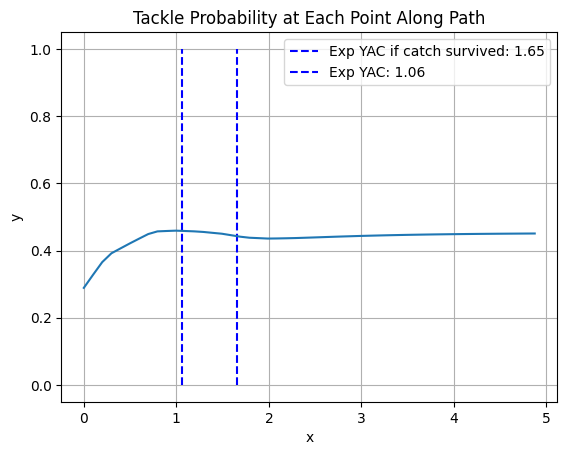

In [13]:

plt.figure()
plt.pcolormesh(XX, YY, probField, cmap='grey', shading='auto')
plt.colorbar(label='P1 Ownership Probability')
plt.xlabel('x')
plt.ylabel('y')
plt.title('P1 vs P2 Team Ownership Probability Map with Sample Paths')
plt.gca().set_aspect('equal')
#Sample paths
xs,ys=zip(*pts)
plt.plot(xs,ys,c='red',linewidth=2)
plt.show()

plt.figure()
p_survive, pkt=calc_prob_of_tackle_along_path(pts, XX,YY,probField,locald)
exp_val=expected_val_receiver(pts, p_survive, pkt, move_direc="y")
print("Expected y position of receiver along path:", exp_val)
print("P_Survive:", p_survive)
plt.plot(pkt)
plt.yscale('log')
plt.title('Probability of Tackle Along Sample Path')
plt.xlabel('Path Point Index')
plt.ylabel('Probability of Tackle at Point')
plt.grid()
plt.show()

plt.figure()
yd=[]
pkvals=[]
for pt in pts:
    rx,ry=pt
    yd.append(rx)
    pk_val=pk(rx,ry,XX,YY,probField)
    pkvals.append(pk_val)
plt.vlines(exp, ymin=0, ymax=1, color='blue', linestyle='dashed', label='Exp YAC if catch survived: {:.2f}'.format(exp))
plt.vlines(exp*prob, ymin=0, ymax=1, color='blue', linestyle='dashed', label='Exp YAC: {:.2f}'.format(prob*exp))
plt.plot(yd,pkvals)
plt.title('Tackle Probability at Each Point Along Path')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

In [14]:
print(end_coords)
rec_info=(91.41, 12.83, 1.3038404810405415, -1.6475682180647133)
def_pos = ((93.17, 9.82), (93.25, 15.56))
def_vmags = (4.404543109109081,4.810405388322294)
def_vts=(2.452668265374935, -1.9320000822885808)

((91.41, 12.83, 1.3038404810405415, -1.6475682180647133), ((93.17, 9.82), (93.25, 15.56)), (4.404543109109081, 4.810405388322294), (2.452668265374935, -1.9320000822885808))


In [15]:
def fullProc(rec_info,def_pos,def_vmags,def_vts):
    XX,YY,combined=get_voronoi_coords(rec_info,def_pos,def_vmags,def_vts)
    probField= hazToProb(combined)
    pts,exp,locald=get_best_path(XX,YY,probField)
    avg,maxv,minv=get_avg(combined)
    prob=avg_to_prob(avg)
    return prob, exp


0.39582056484653194 0.5127386376907739 0.25986730645126904


(0.6504001786308049, 1.7471163903765663)

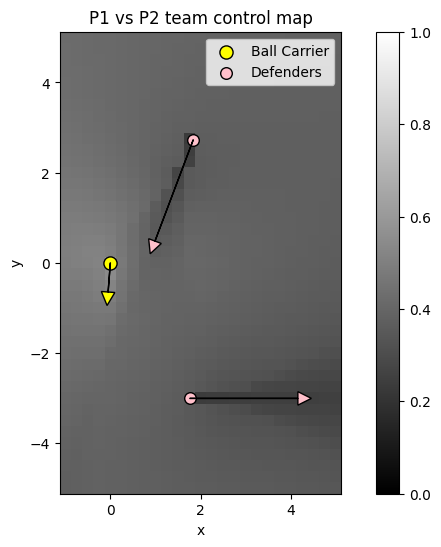

In [76]:
fullProc(rec_info,def_pos,def_vmags,def_vts)

((91.0, 14.32, 2.6172504656605233, -0.8124186125846928), ((81.6, 23.72), (95.28, 8.61), (102.5, 15.43), (93.61, 18.39), (93.88, 31.03), (87.72, 48.11), (95.2, 37.52), (93.33, 37.95), (94.14, 11.24), (91.26, 32.96), (103.4, 33.5), (95.9, 46.36)), (0.4472135955000278, 1.2000000000000455, 2.23606797749978, 2.02484567313164, 2.7313000567495305, 1.835755975068569, 3.4438350715445583, 6.400781202322134, 6.2649820430709005, 3.1622776601684017, 2.863564212655306, 1.7204650534085384), (-2.0344439357958803, 3.141592653589793, -0.17985349979248325, -0.9964914966201922, 1.1562894522101126, 1.0584068664841335, 1.120135000714251, 0.5055810548742066, 0.42794849632147697, 0.9652516631899053, 0.43240777557052223, 0.6202494859828263))
((91.41, 12.83, 1.3038404810405415, -1.6475682180647133), ((93.17, 9.82), (93.25, 15.56)), (4.404543109109081, 4.810405388322294), (2.452668265374935, -1.9320000822885808))
0.4350538553107592 0.5917877336942869 0.24280437670181684


(0.6792772254033067, 2.0686280268116417)

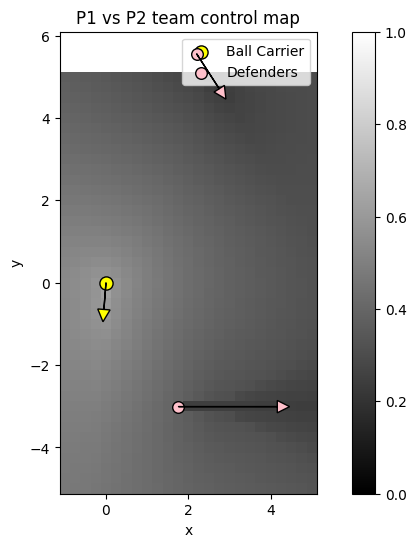

In [65]:
print(start_coords)
print(end_coords)
def1_s_pos=(95.28, 8.61)
def2_s_pos=(93.61, 18.39)
def_start_pos=[(95.28, 8.61),(93.61, 18.39)]

def1_s_v=1.2000000000000455
def2_s_v=2.02484567313164
def_start_v=[1.2,2.02484567313164]

def1_s_vt=3.141592653589793
def2_s_vt=-0.9964914966201922
def_start_vt=[np.pi,-0.99649]

fullProc(rec_info,(def_pos[0],def_start_pos[1]),(def_vmags[0],def_start_v[1]),(def_vts[0],def_start_vt[1]))

In [ ]:
rec_info=(91.41, 12.83, 1.3038404810405415, -1.6475682180647133)
def_pos = [(93.17, 9.82), (93.25, 15.56)]
def1_vmag=4.404543109109081
def1_vt=2.452668265374935

def2_vmag=4.810405388322294
def2_vt=-1.9320000822885808


def_vmap=np.linspace(0.1,4.8,5)
def_vtmap=np.linspace(0,2*np.pi,20)


vv, tt = np.meshgrid(def_vmap, def_vtmap, indexing='ij')
pairs = np.column_stack([vv.ravel(), tt.ravel()])  # (100, 2)

probs = []
exps = []

for v, theta in pairs:
    def_vmags = (v, def2_vmag)
    def_vts   = (theta, def2_vt)
    prob, exp = fullProc(rec_info, def_pos, def_vmags, def_vts)
    probs.append(prob)
    exps.append(exp)

probs = np.array(probs)
exps  = np.array(exps)

pairs_with_results = np.column_stack([pairs, probs, exps])  # shape (100, 4)

# columns: [v, theta, prob, exp]


#fullProc(rec_info,def_pos,def_vmags,def_vts)

In [19]:
# Extract columns
probs = pairs_with_results[:, 2]
exps  = pairs_with_results[:, 3]

Q = probs * exps

# index of minimum Q
idx = np.argmin(Q)

# retrieve the corresponding row
v_min, theta_min, prob_min, exp_min = pairs_with_results[idx]

# the minimum value
Q_min = Q[idx]

print("Minimum Q =", Q_min)
print("At:")
print("  v     =", v_min)
print("  theta =", theta_min)
print("  prob  =", prob_min)
print("  exp   =", exp_min)


Minimum Q = 0.9011465533214174
At:
  v     = 3.6250000000000004
  theta = 1.6534698176788385
  prob  = 0.5952262296475818
  exp   = 1.5139563890774155


Min Q = prob*exp = 0.5945
  at v = 4.800, theta = 1.653 rad (94.7°)
  prob = 0.5945, exp = 1.5323


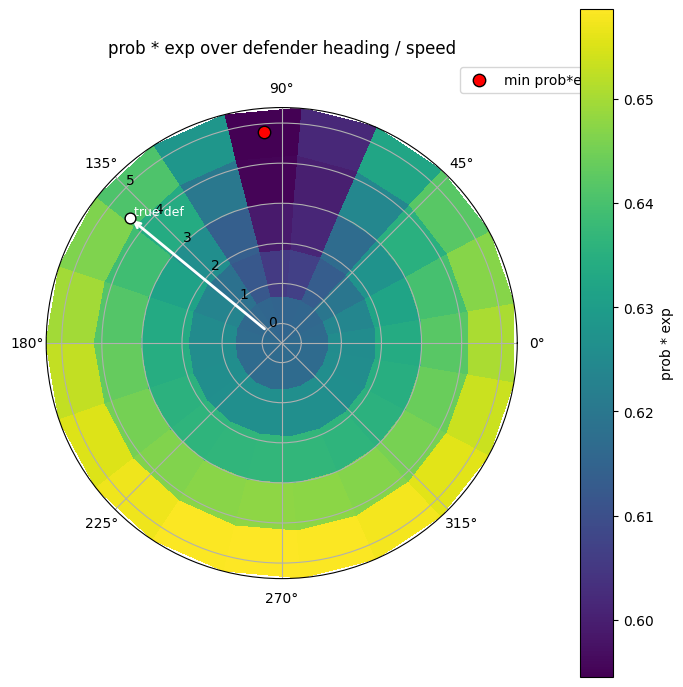

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# --- Assuming you already have this ---
# def2_vmap: speeds, shape (n_v,)
# def2_vtmap: headings (radians), shape (n_t,)
# pairs_with_results: columns [v, theta, prob, exp] in meshgrid order

true_theta = def1_vt     # radians
true_speed = def1_vmag    # m/s



v_vals  = pairs_with_results[:, 0]
theta   = pairs_with_results[:, 1]
probs   = pairs_with_results[:, 2]
exps    = pairs_with_results[:, 3]

# 1) Compute quantity of interest
Q = probs  # shape (n_v * n_t,)

# 2) Find minimum and corresponding (v, theta)
idx_min = np.argmin(Q)
v_min, theta_min, prob_min, exp_min = pairs_with_results[idx_min]
Q_min = Q[idx_min]

print(f"Min Q = prob*exp = {Q_min:.4f}")
print(f"  at v = {v_min:.3f}, theta = {theta_min:.3f} rad "
      f"({np.degrees(theta_min):.1f}°)")
print(f"  prob = {prob_min:.4f}, exp = {exp_min:.4f}")

# 3) Reshape Q back to grid (must match how you built the meshgrid)
n_v = def_vmap.size
n_t = def_vtmap.size
Q_grid = Q.reshape(n_v, n_t)  # speeds along axis 0, headings along axis 1

# Build polar grid: same shapes as Q_grid
Theta, R = np.meshgrid(def_vtmap, def_vmap)  # both (n_v, n_t)

# 4) Polar heatmap
# --- existing code that makes the polar plot ---

fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111, projection='polar')

pcm = ax.pcolormesh(
    Theta, R, Q_grid,
    shading='auto'
)
cbar = fig.colorbar(pcm, ax=ax, pad=0.1)
cbar.set_label('prob * exp')

# Mark the minimum point
ax.scatter(
    theta_min, v_min,
    c='red', edgecolors='k', s=80, zorder=5,
    label='min prob*exp'
)

# >>> NEW: arrow for true defender motion <<<
ax.annotate(
    '',                           # no text
    xy=(true_theta, true_speed),  # arrow tip: (theta, r)
    xytext=(true_theta, 0.0),     # arrow tail at origin along same angle
    arrowprops=dict(
        arrowstyle='->',
        color='white',
        linewidth=2
    ),
    zorder=6
)

# Optional: put a dot at the tip and a legend label
ax.scatter(true_theta, true_speed, c='white', edgecolors='k', s=60, zorder=7)
ax.text(
    true_theta, true_speed,
    " true def", color='white',
    fontsize=9, ha='left', va='bottom'
)

# Cosmetics
ax.set_title('prob * exp over defender heading / speed', pad=20)
ax.set_rlabel_position(135)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.tight_layout()
plt.show()



In [35]:
mega_path = '/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/mega_df.parquet'
mega_df = pd.read_parquet(mega_path)
print('Loaded mega_df:', mega_df.shape)
display(mega_df.head())

Loaded mega_df: (13920, 4)


,receiver_final,defender_positions,defender_v_mags,defender_v_dirs
0,"[91.0, 14.32, 2.6172504656605233, -0.812418612...","[[-1.5, 0.5], [-2.25, 3.75]]","[1.498094057591338, 8.14605178130639]","[3.1080572525021224, 2.0702677607058]"
1,"[91.0, 14.32, 2.6172504656605233, -0.812418612...","[[-1.5, 0.5], [-3.0, -0.75]]","[1.498094057591338, 7.090581150926676]","[3.1080572525021224, 3.377050465820977]"
2,"[91.0, 14.32, 2.6172504656605233, -0.812418612...","[[-1.5, 0.5], [-4.5, 1.75]]","[1.498094057591338, 9.044088909869425]","[3.1080572525021224, 2.7636128123526134]"
3,"[91.0, 14.32, 2.6172504656605233, -0.812418612...","[[-1.5, 0.5], [-1.0, 1.25]]","[1.498094057591338, 0.1]","[3.1080572525021224, 1.6389251469159989]"
4,"[91.0, 14.32, 2.6172504656605233, -0.812418612...","[[-1.5, 0.5], [-1.0, 1.25]]","[1.498094057591338, 0.1]","[3.1080572525021224, 1.813458072115432]"


In [36]:
def1_s_pos=(95.28, 8.61)
def2_s_pos=(93.61, 18.39)

def _add_abs(def_pos):
    try:
        (dx1, dy1), (dx2, dy2) = def_pos
        return [
            (def1_s_pos[0] + float(dx1), def1_s_pos[1] + float(dy1)),
            (def2_s_pos[0] + float(dx2), def2_s_pos[1] + float(dy2)),
        ]
    except Exception:
        return [(np.nan, np.nan), (np.nan, np.nan)]

mega_df['defender_positions_abs'] = mega_df['defender_positions'].apply(_add_abs)

# quick check
mega_df.head()

,receiver_final,defender_positions,defender_v_mags,defender_v_dirs,defender_positions_abs
0,"[91.0, 14.32, 2.6172504656605233, -0.812418612...","[[-1.5, 0.5], [-2.25, 3.75]]","[1.498094057591338, 8.14605178130639]","[3.1080572525021224, 2.0702677607058]","[(93.78, 9.11), (91.36, 22.14)]"
1,"[91.0, 14.32, 2.6172504656605233, -0.812418612...","[[-1.5, 0.5], [-3.0, -0.75]]","[1.498094057591338, 7.090581150926676]","[3.1080572525021224, 3.377050465820977]","[(93.78, 9.11), (90.61, 17.64)]"
2,"[91.0, 14.32, 2.6172504656605233, -0.812418612...","[[-1.5, 0.5], [-4.5, 1.75]]","[1.498094057591338, 9.044088909869425]","[3.1080572525021224, 2.7636128123526134]","[(93.78, 9.11), (89.11, 20.14)]"
3,"[91.0, 14.32, 2.6172504656605233, -0.812418612...","[[-1.5, 0.5], [-1.0, 1.25]]","[1.498094057591338, 0.1]","[3.1080572525021224, 1.6389251469159989]","[(93.78, 9.11), (92.61, 19.64)]"
4,"[91.0, 14.32, 2.6172504656605233, -0.812418612...","[[-1.5, 0.5], [-1.0, 1.25]]","[1.498094057591338, 0.1]","[3.1080572525021224, 1.813458072115432]","[(93.78, 9.11), (92.61, 19.64)]"


In [ ]:
# Run fullProc for each row and store results with a progress bar.
# Relies on existing names: mega_df, fullProc, tqdm, np
final_coords=prep_for_heat(13975,df_out_merged,n=2)

#def _safe_fullProc(rec, def_pos, def_vmags, def_vts):
    try:
        # ensure the inputs are tuples (fullProc expects these shapes)
        rec_t = tuple(rec)
        def_pos_t = tuple(def_pos)
        def_vmags_t = tuple(def_vmags)
        def_vts_t = tuple(def_vts)
        return fullProc(rec_t, def_pos_t, def_vmags_t, def_vts_t)
    except Exception:
        return (np.nan, np.nan)

results = []
it = mega_df[['receiver_final','defender_positions_abs','defender_v_mags','defender_v_dirs']].iterrows()
for idx, row in tqdm(it, total=len(mega_df), desc='Running fullProc'):
    results.append(_safe_fullProc(final_coords[0],
                                 row['defender_positions_abs'],
                                 row['defender_v_mags'],
                                 row['defender_v_dirs']))

# Attach results to dataframe
mega_df['pr oc_result'] = results
mega_df[['proc_prob', 'proc_exp']] = pd.DataFrame(results, index=mega_df.index)

print(f"Finished: {len(mega_df)} rows processed. proc_prob NaNs: {mega_df['proc_prob'].isna().sum()}")

Running fullProc:   0%|          | 0/13920 [00:00<?, ?it/s]

Finished: 13920 rows processed. proc_prob NaNs: 0


In [38]:
# create new column proc_prob*proc_exp in mega_df
if 'proc_prob' in mega_df.columns and 'proc_exp' in mega_df.columns:
    mega_df['proc_prob_exp'] = mega_df['proc_prob'] * mega_df['proc_exp']
else:
    # fallback: try to use `results` list if available (each item (prob, exp))
    if 'results' in globals():
        arr = np.asarray(results, dtype=float)
        if arr.ndim == 2 and arr.shape[1] >= 2 and len(arr) == len(mega_df):
            mega_df['proc_prob'] = arr[:, 0]
            mega_df['proc_exp'] = arr[:, 1]
            mega_df['proc_prob_exp'] = mega_df['proc_prob'] * mega_df['proc_exp']
        else:
            mega_df['proc_prob_exp'] = np.nan
    else:
        mega_df['proc_prob_exp'] = np.nan

# quick check
mega_df[['proc_prob', 'proc_exp', 'proc_prob_exp']].head()

,proc_prob,proc_exp,proc_prob_exp
0,0.734623,2.451453,1.800894
1,0.708029,2.233682,1.581511
2,0.734229,2.445702,1.795705
3,0.673159,1.995079,1.343005
4,0.673159,1.995079,1.343006


In [63]:
# Find 10 rows with smallest proc_prob_exp where both defender speeds are non-zero

# ensure proc_prob_exp exists
if 'proc_prob_exp' not in mega_df.columns:
    mega_df['proc_prob_exp'] = mega_df['proc_prob'] * mega_df['proc_exp']

def _both_nonzero(vs):
    try:
        a = list(vs)
        if len(a) < 2:
            return False
        return (not np.isclose(float(a[0]), 0.0)) and (not np.isclose(float(a[1]), 0.0))
    except Exception:
        return False

mask = mega_df['defender_v_mags'].apply(_both_nonzero) & mega_df['proc_prob_exp'].notna()

smallest10 = mega_df.loc[mask].sort_values('proc_exp', ascending=True).head(10).copy()

# show relevant columns
display(smallest10[['receiver_final', 'defender_positions', 'defender_v_mags', 'proc_prob', 'proc_exp', 'proc_prob_exp']])

,receiver_final,defender_positions,defender_v_mags,proc_prob,proc_exp,proc_prob_exp
33,"[91.0, 14.32, 2.6172504656605233, -0.812418612...","[[-1.5, 0.5], [0.0, -0.5]]","[1.498094057591338, 0.1]",0.657517,1.897536,1.247662
32,"[91.0, 14.32, 2.6172504656605233, -0.812418612...","[[-1.5, 0.5], [0.0, -0.5]]","[1.498094057591338, 0.1]",0.657735,1.898883,1.248962
35,"[91.0, 14.32, 2.6172504656605233, -0.812418612...","[[-1.5, 0.5], [0.0, -0.5]]","[1.498094057591338, 2.6]",0.665426,1.916360,1.275197
2529,"[91.0, 14.32, 2.6172504656605233, -0.812418612...","[[1.0, 0.5], [0.0, -0.5]]","[0.1, 0.1]",0.658967,1.922439,1.266824
2528,"[91.0, 14.32, 2.6172504656605233, -0.812418612...","[[1.0, 0.5], [0.0, -0.5]]","[0.1, 0.1]",0.659187,1.923806,1.268147
4641,"[91.0, 14.32, 2.6172504656605233, -0.812418612...","[[-0.25, -0.5], [0.0, -0.5]]","[0.1, 0.1]",0.661093,1.928311,1.274794
4737,"[91.0, 14.32, 2.6172504656605233, -0.812418612...","[[-0.25, -0.5], [0.0, -0.5]]","[0.1, 0.1]",0.661314,1.929530,1.276026
4640,"[91.0, 14.32, 2.6172504656605233, -0.812418612...","[[-0.25, -0.5], [0.0, -0.5]]","[0.1, 0.1]",0.661315,1.929701,1.276141
4833,"[91.0, 14.32, 2.6172504656605233, -0.812418612...","[[-0.25, -0.5], [0.0, -0.5]]","[0.1, 0.1]",0.661399,1.930490,1.276824
4736,"[91.0, 14.32, 2.6172504656605233, -0.812418612...","[[-0.25, -0.5], [0.0, -0.5]]","[0.1, 0.1]",0.661536,1.930921,1.277375


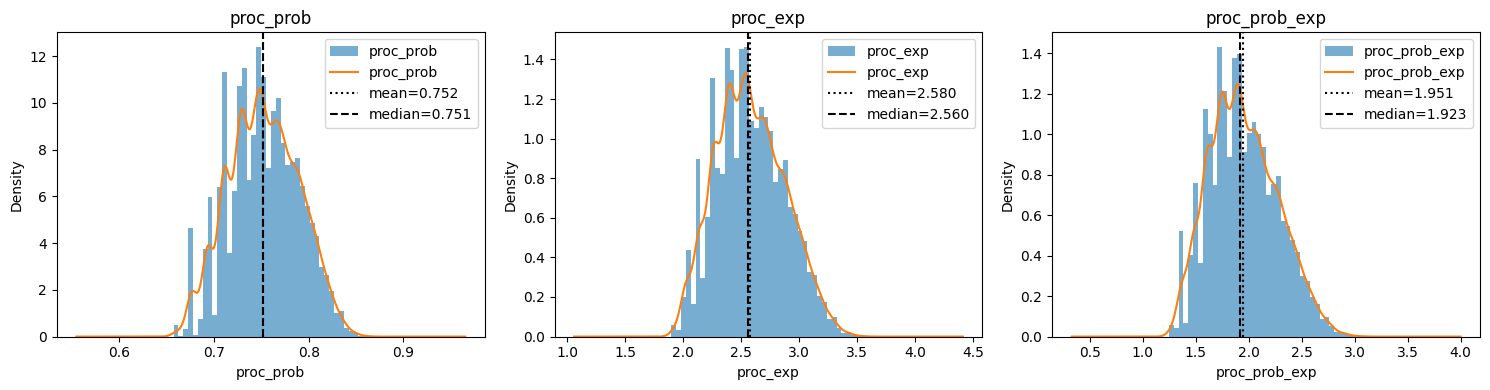

In [64]:
# plot distributions for proc_prob, proc_exp, proc_prob_exp
cols = ['proc_prob', 'proc_exp', 'proc_prob_exp']
available = [c for c in cols if c in mega_df.columns]

if not available:
    raise RuntimeError("None of proc_prob / proc_exp / proc_prob_exp exist in mega_df")

plt.figure(figsize=(15, 4))
for i, col in enumerate(cols):
    if col not in mega_df.columns:
        continue
    ax = plt.subplot(1, 3, i + 1)
    ser = mega_df[col].dropna().astype(float)
    if ser.empty:
        ax.text(0.5, 0.5, "no data", ha='center', va='center')
        ax.set_title(col)
        continue

    # histogram + KDE
    ser.plot.hist(bins=40, density=True, alpha=0.6, ax=ax, color='C0')
    try:
        ser.plot.kde(ax=ax, color='C1')
    except Exception:
        pass

    # stats lines
    ax.axvline(ser.mean(), color='k', linestyle=':', label=f"mean={ser.mean():.3f}")
    ax.axvline(ser.median(), color='k', linestyle='--', label=f"median={ser.median():.3f}")
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.legend()

plt.tight_layout()
plt.show()


In [44]:
def get_row_features(row_number):
    """
    Return [receiver_final, defender_positions_abs, defender_v_mags, defender_v_dirs]
    for a given row in mega_df.

    row_number: int (positional index using .iloc) or any valid index label for mega_df (.loc).
    Raises IndexError/KeyError on invalid input.
    """
    cols = ['receiver_final', 'defender_positions_abs', 'defender_v_mags', 'defender_v_dirs']

    # choose by positional index if an int was provided
    if isinstance(row_number, int):
        try:
            row = mega_df.iloc[row_number]
        except Exception as e:
            raise IndexError(f"Positional index {row_number} out of range") from e
    else:
        try:
            row = mega_df.loc[row_number]
        except Exception as e:
            raise KeyError(f"Index label {row_number} not found in mega_df") from e

    # if .loc returned a DataFrame (multiple rows), take the first match
    if isinstance(row, type(mega_df)):
        row = row.iloc[0]

    # extract values with safe fallback
    result = []
    for c in cols:
        if c in mega_df.columns:
            result.append(row.get(c, np.nan))
        else:
            result.append(np.nan)

    return result

In [46]:
final_coords=prep_for_heat(13975,df_out_merged,n=2)
print(final_coords)
print(get_row_features(0))

((91.41, 12.83, 1.3038404810405415, -1.6475682180647133), ((93.17, 9.82), (93.25, 15.56)), (4.404543109109081, 4.810405388322294), (2.452668265374935, -1.9320000822885808))
[array([91.        , 14.32      ,  2.61725047, -0.81241861]), [(93.78, 9.11), (91.36, 22.14)], array([1.49809406, 8.14605178]), array([3.10805725, 2.07026776])]


In [47]:
import matplotlib.pyplot as plt
import numpy as np


def plot_prep_for_heat_output(
    rec_and_defs,
    defender_positions=None,
    defender_v_mags=None,
    defender_v_dirs=None,
    ax=None,
    abs_positions=False,
    ref_receiver_pos=None,
    arrow_scale=1.0,
    show_labels=True,
    figsize=(6, 6),
):
    """
    Plot receiver and defender locations and velocity vectors.

    Accepts either:
    1) a single value rec_and_defs equal to the tuple returned by prep_for_heat(id, ...):
       (rec_info, defender_positions, defender_v_mags, defender_v_dirs)
       where rec_info = (recv_x, recv_y, recv_v_mag, recv_v_dir) and
       defender_positions = ((d1x,d1y),(d2x,d2y), ...)
    OR
    2) call with rec_and_defs = rec_info and pass defender_positions,
       defender_v_mags, defender_v_dirs

    Parameters
    ----------
    rec_and_defs:
        Either rec_info tuple or the full tuple returned by prep_for_heat.
    defender_positions:
        Optional list/tuple of (x,y) for defenders (used if rec_and_defs is rec_info).
    defender_v_mags:
        Optional list/tuple of velocity magnitudes for defenders.
    defender_v_dirs:
        Optional list/tuple of velocity directions (radians) for defenders.
    ax:
        Optional matplotlib Axes to draw on. If None, a new figure+ax is created.
    abs_positions:
        If True, treat defender_positions as absolute coords (default False).
    ref_receiver_pos:
        If abs_positions=False, this tuple (rx_abs, ry_abs) will be added to
        defender positions to convert relative -> absolute for display.
        If None and abs_positions=False, defenders are plotted relative to receiver.
    arrow_scale:
        Multiplier applied to velocity vector lengths for visibility.
    show_labels:
        Whether to annotate points with text labels.
    figsize:
        Figure size when creating a new figure.

    Returns
    -------
    fig, ax : matplotlib Figure and Axes objects.
    """

    # --- Unpack inputs depending on call style ---
    if defender_positions is None and defender_v_mags is None and defender_v_dirs is None:
        # Expect rec_and_defs to be the full prep_for_heat output
        try:
            rec_info, defender_positions, defender_v_mags, defender_v_dirs = rec_and_defs
        except Exception as e:
            raise ValueError(
                "When not passing defenders separately, rec_and_defs must be "
                "the full tuple returned by prep_for_heat"
            ) from e
    else:
        # rec_and_defs is rec_info
        rec_info = rec_and_defs

    # Normalize defender containers
    defender_positions = tuple(defender_positions) if defender_positions is not None else tuple()
    defender_v_mags = tuple(defender_v_mags) if defender_v_mags is not None else tuple()
    defender_v_dirs = tuple(defender_v_dirs) if defender_v_dirs is not None else tuple()

    if not (len(defender_positions) == len(defender_v_mags) == len(defender_v_dirs)):
        raise ValueError(
            "defender_positions, defender_v_mags, and defender_v_dirs must all "
            "have the same length."
        )

    # rec_info -> (rx, ry, r_vmag, r_vdir)
    try:
        rx, ry, r_vmag, r_vdir = map(float, rec_info)
    except Exception:
        raise ValueError("rec_info must be a 4-tuple (rx, ry, r_vmag, r_vdir)")

    # --- Prepare axes ---
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        created_fig = True
    else:
        fig = ax.figure

    # --- Plot receiver ---
    ax.scatter(rx, ry, s=120, c="red", zorder=5, label="Receiver")

    # draw receiver velocity arrow
    rvx = r_vmag * np.cos(r_vdir) * arrow_scale
    rvy = r_vmag * np.sin(r_vdir) * arrow_scale
    ax.arrow(
        rx,
        ry,
        rvx,
        rvy,
        head_width=0.3 * arrow_scale,
        head_length=0.4 * arrow_scale,
        fc="red",
        ec="red",
        length_includes_head=True,
        zorder=6,
    )

    if show_labels:
        ax.text(rx, ry, " REC", color="red", fontsize=9, va="center")
        ax.text(
            rx + rvx,
            ry + rvy,
            f"{r_vmag:.2f}@{np.degrees(r_vdir):.0f}°",
            color="red",
            fontsize=8,
        )

    # --- Plot defenders ---
    all_x = [rx]
    all_y = [ry]

    for i, (dpos, dmag, ddir) in enumerate(
        zip(defender_positions, defender_v_mags, defender_v_dirs)
    ):
        try:
            dx, dy = map(float, dpos)
        except Exception:
            # skip malformed defender entry
            continue

        # If positions are relative and a reference absolute receiver position is provided, translate
        if (not abs_positions) and (ref_receiver_pos is not None):
            dx_abs = ref_receiver_pos[0] + dx
            dy_abs = ref_receiver_pos[1] + dy
        else:
            dx_abs = dx
            dy_abs = dy

        all_x.append(dx_abs)
        all_y.append(dy_abs)

        ax.scatter(dx_abs, dy_abs, s=80, c="blue", zorder=5)

        dvx = float(dmag) * np.cos(float(ddir)) * arrow_scale
        dvy = float(dmag) * np.sin(float(ddir)) * arrow_scale
        ax.arrow(
            dx_abs,
            dy_abs,
            dvx,
            dvy,
            head_width=0.2 * arrow_scale,
            head_length=0.3 * arrow_scale,
            fc="blue",
            ec="blue",
            length_includes_head=True,
            zorder=6,
        )

        if show_labels:
            ax.text(dx_abs, dy_abs, f" D{i+1}", color="blue", fontsize=9, va="center")
            ax.text(
                dx_abs + dvx,
                dy_abs + dvy,
                f"{dmag:.2f}@{np.degrees(ddir):.0f}°",
                color="blue",
                fontsize=8,
            )

    # --- Cosmetic: equal aspect and padding ---
    ax.set_aspect("equal")

    pad = 3.0 * arrow_scale
    if all_x and all_y:
        try:
            ax.set_xlim(min(all_x) - pad, max(all_x) + pad)
            ax.set_ylim(min(all_y) - pad, max(all_y) + pad)
        except Exception:
            pass

    if show_labels:
        ax.legend(loc="best")

    if created_fig:
        plt.show()

    return fig, ax


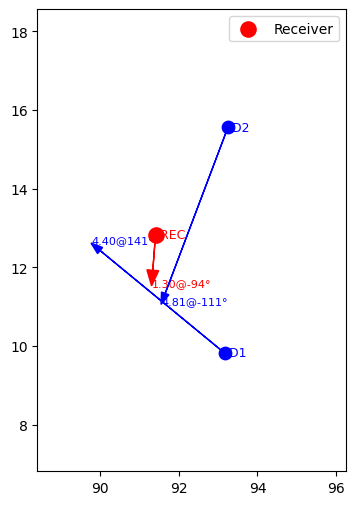

[(95.03, 8.11), (93.61, 17.89)] [0.1 0.1] [3.48943893 3.88996021]


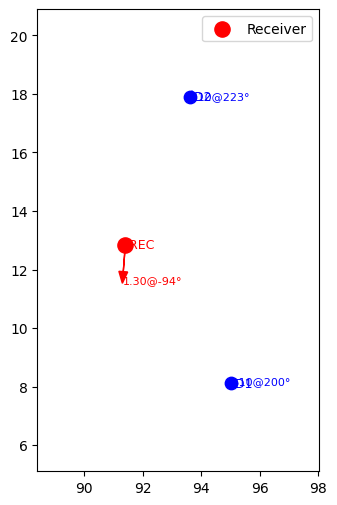

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [52]:
plot_prep_for_heat_output(*final_coords)
r,dp,dv,dt=get_row_features(4833)
print(dp,dv,dt)
plot_prep_for_heat_output(final_coords[0],dp,dv,dt)

0.3833932504571218 0.4593247957435721 0.3073090921607362


Text(0, 0.5, 'Y (yds)')

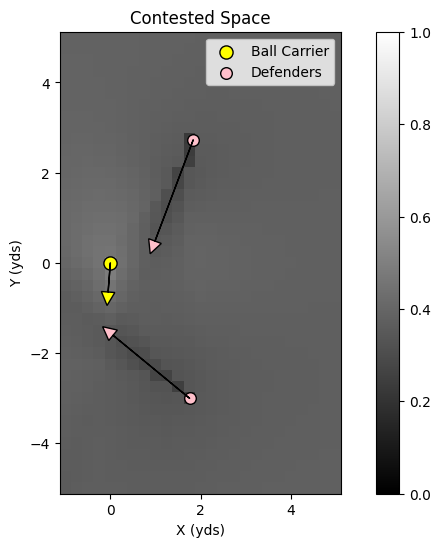

In [77]:
fullProc(*final_coords)
plt.title("Contested Space")
plt.xlabel("X (yds)")
plt.ylabel("Y (yds)")